<a href="https://colab.research.google.com/github/chethana613/artificial-intelligence/blob/main/Robby_QL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Test-average is:  186.02
The Test-standard-deviation is:  90.4615918498011


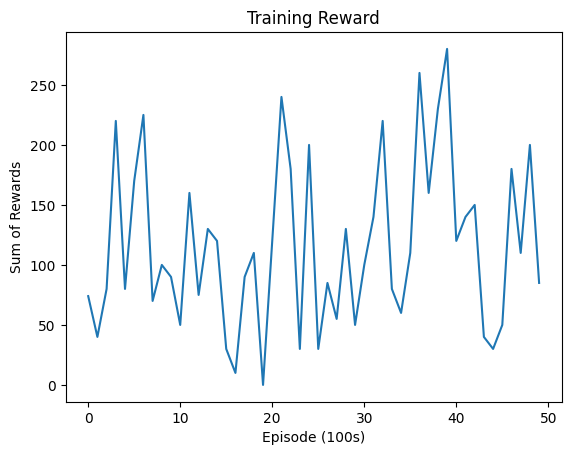

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Initializing the Q-matrix which is a 10 x 10 grid
qMatrix = None

# Rewards that Robby would receive by doing certain actions
CAN = 10
WALL = -5
EMPTY = -1

# States
CANSTATE = 0
WALLSTATE = 1
EMPTYSTATE = 2

# Initializing the values, N (episodes), M(actions)
# Part 2: Experiment with learning rate, here eta can be a value [0,1]. So consider eta = 0.8, 0.6, 0.4, 0.2
N = 5000
M = 200
eta = 0.2
gamma = 0.9

# Defining the class Grid
class Grid:
    def __init__(self, robby=(-1, -1)):
        self.grid = np.zeros((10, 10))
        for x in range(10):
            for y in range(10):
                self.grid[x, y] = random.randint(0, 1)
        self.robby = robby

    def newLocation(self, loc=(0, 0)):
        self.robby = loc

# Defining the class Robot - this class consists of Robby’s actions and sensors
class Robot:
    def __init__(self):
        self.xCoor = random.randint(0, 9)
        self.yCoor = random.randint(0, 9)
        self.reward = 0
        self.senseCurrent = -1
        self.senseNorth = -1
        self.senseSouth = -1
        self.senseEast = -1
        self.senseWest = -1
        self.rGrid = Grid((self.xCoor, self.yCoor))

    # Calculate the state in the Q-matrix
    def myState(self):
        qMatrixState = (3**0)*self.senseCurrent + (3**1)*self.senseEast + (3**2)*self.senseWest + (3**3)*self.senseSouth + (3**4)*self.senseNorth
        return qMatrixState

    # Sensors
    def sensor(self):
        # Current
        if self.rGrid.grid[self.xCoor, self.yCoor] == 1:
            self.senseCurrent = CANSTATE
        else:
            self.senseCurrent = EMPTYSTATE

        # North
        if self.xCoor == 0:
            self.senseNorth = WALLSTATE
        elif self.rGrid.grid[self.xCoor - 1, self.yCoor] == 1:
            self.senseNorth = CANSTATE
        else:
            self.senseNorth = EMPTYSTATE

        # South
        if self.xCoor == 9:
            self.senseSouth = WALLSTATE
        elif self.rGrid.grid[self.xCoor + 1, self.yCoor] == 1:
            self.senseSouth = CANSTATE
        else:
            self.senseSouth = EMPTYSTATE

        # East
        if self.yCoor == 9:
            self.senseEast = WALLSTATE
        elif self.rGrid.grid[self.xCoor, self.yCoor + 1] == 1:
            self.senseEast = CANSTATE
        else:
            self.senseEast = EMPTYSTATE

        # West
        if self.yCoor == 0:
            self.senseWest = WALLSTATE
        elif self.rGrid.grid[self.xCoor, self.yCoor - 1] == 1:
            self.senseWest = CANSTATE
        else:
            self.senseWest = EMPTYSTATE

    # Actions
    def moveNorth(self):
        # If we are at the most north point, and try to go north, hit wall
        if self.xCoor == 0:
            self.reward += WALL
            self.sensor()
            return WALL
        else:
            self.xCoor -= 1
            self.rGrid.newLocation((self.xCoor, self.yCoor))
            self.sensor()
            return 0

    def moveSouth(self):
        if self.xCoor == 9:
            self.reward += WALL
            self.sensor()
            return WALL
        else:
            self.xCoor += 1
            self.rGrid.newLocation((self.xCoor, self.yCoor))
            self.sensor()
            return 0

    def moveEast(self):
        if self.yCoor == 9:
            self.reward += WALL
            self.sensor()
            return WALL
        else:
            self.yCoor += 1
            self.rGrid.newLocation((self.xCoor, self.yCoor))
            self.sensor()
            return 0

    def moveWest(self):
        if self.yCoor == 0:
            self.reward += WALL
            self.sensor()
            return WALL
        else:
            self.yCoor -= 1
            self.rGrid.newLocation((self.xCoor, self.yCoor))
            self.sensor()
            return 0

    def pickUpCan(self):
        if self.rGrid.grid[self.xCoor, self.yCoor]:
            self.reward += CAN
            self.rGrid.grid[self.xCoor, self.yCoor] = 0
            self.sensor()
            return CAN
        else:
            self.reward += EMPTY
            return EMPTY

    def randomAction(self, random_action):
        if random_action == 0:
            return self.moveNorth()
        elif random_action == 1:
            return self.moveSouth()
        elif random_action == 2:
            return self.moveEast()
        elif random_action == 3:
            return self.moveWest()
        elif random_action == 4:
            return self.pickUpCan()

# Defining the main function
# Part 3: Experiment with epsilon, varying the value of epsilon to see the changes in the result. Epsilon = 0.9, 0.65, 0.1
def main():
    # Initial training for Robby
    epsilon = 0.1
    qMatrix = np.zeros((3**5, 5))  # (states, actions)
    count = 0
    rewards = []

    for epoch in range(N):
        robby = Robot()
        for step in range(M):
            # Observe Robby's current state
            currentState = robby.myState()
            reward = 0

            # Choose an action a using e-greedy action selection
            action = None
            if random.random() < epsilon:  # Take random action
                action = random.randint(0, 4)
                # Receive reward
                reward = robby.randomAction(action)
            else:
                # If all actions are zero, choose one at random
                if np.count_nonzero(qMatrix[robby.myState(), :]) == 0:
                    action = random.randint(0, 4)
                else:  # Else choose the best action
                    action = np.argmax(qMatrix[robby.myState(), :])
                # Receive reward
                reward = robby.randomAction(action)

            # Calculate formula
            old_q_value = qMatrix[currentState, action]
            # Observe Robby's new state
            max_q_value = max(qMatrix[robby.myState(), :])
            # Update Q formula
            qMatrix[currentState, action] += eta * (reward + gamma * (int(max_q_value) - old_q_value))

        if epoch % 50 == 0 and epsilon >= 0.05:
            epsilon -= 0.05

        if epoch % 100 == 0:
            rewards.append(robby.reward)

    # Now run again with epsilon set at 0.1, using the same trained Q-matrix
    # This time, the Q-matrix is not updated.
    epsilon = 0.1
    trainedReward = []

    for epoch in range(N):
        robby = Robot()
        for step in range(M):
            currentState = robby.myState()
            reward = 0
            action = None

            if random.random() < epsilon:  # Take random action
                action = random.randint(0, 4)
                reward = robby.randomAction(action)
            else:
                # If all actions are zero, choose one at random
                if np.count_nonzero(qMatrix[robby.myState(), :]) == 0:
                    action = random.randint(0, 4)
                else:  # Else choose the best action
                    action = np.argmax(qMatrix[robby.myState(), :])
                reward = robby.randomAction(action)

        if epoch % 100 == 0:
            trainedReward.append(robby.reward)

    print("The Test-average is: ", np.average(trainedReward))
    print("The Test-standard-deviation is: ", np.std(trainedReward))

    plt.plot(rewards)
    plt.ylabel('Sum of Rewards')
    plt.xlabel('Episode (100s)')
    plt.title('Training Reward')
    plt.show()

if __name__ == '__main__':
    main()
